# Outlines:
- [0-Introduction](#0)
- [1- Import Data and Packages](#1)
- [2- Feature Extraction](#2)
- [3- EDA](#3)
    - [3.1 - Scatter matrix](#3.1)
    - [3.2 - Univariate Analysis](#3.2)
    - [3.3 - Plotting Colinearity](#3.3)
    - [3.4 - Numerical Columns over the date columns](#3.4)
- [4- Preprocessing and Transformers](#4)
    - [4.1- Pipeline](#4.1)
- [5- Feature Importance](#5)
- [6- Modeling](#6)
    - [6.1 - Plot Model Scores](#6.1)
    - [6.2 - Final Model](#6.2)
    - [6.3 - Cross-Validation Scores](#6.3)
- [7- Plot Real/Predicted/Actual Power](#7)

<a name="0"></a>
# Introduction
#### In the modern era, wind turbines have emerged as pivotal components of the global energy landscape. Operating on a straightforward principle, these turbines harness the kinetic energy of the wind to rotate blades connected to a rotor, ultimately driving a generator that produces electricity. This clean and renewable energy source has experienced remarkable growth, with wind power capacity rapidly expanding across continents.
The environmental advantages of wind turbines are profound. They generate no greenhouse gas emissions or air pollutants during operation, making them indispensable in efforts to combat climate change and diminish dependence on fossil fuels. Additionally, wind energy is abundant and everlasting, offering a reliable power source for future generations.

### About Dataset
In Wind Turbines, SCADA Systems measure and save data such as wind speed, wind direction, generated power, etc. at 10-minute intervals. This file contains data from a wind turbine's SCADA system that is operational and generating power in Turkey.

### Content
#### The data in the file includes:

* Date/Time (for 10-minute intervals)
* LV ActivePower (kW): The power generated by the turbine for that moment
* Wind Speed (m/s): The wind speed at the hub height of the turbine (the wind speed that the turbine uses for electricity generation)
* Theoretical Power Curve (KWh): The theoretical power values that the turbine generates with that wind speed, which is provided by the turbine manufacturer
* Wind Direction (°): The wind direction at the hub height of the turbine (wind turbines automatically turn to this direction)

<a name="1"></a>
# 1 - Import Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

In [4]:
df = pd.read_csv('data/T1.csv')
df

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [6]:
df.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [7]:
#There is negative values in the actual power column
count_negative_values = (df['LV ActivePower (kW)'] < 0).sum()
count_negative_values

57

In [9]:
df.loc[df['LV ActivePower (kW)'] < 0, 'LV ActivePower (kW)'] = 0

<a name="2"></a>
# 2 - Feature Extraction
#### Extract new features from the Date/Time Column

In [10]:
#Save a copy for the pipeline and split it
df_copy=df.copy()

In [11]:
df['Date/Time']=pd.to_datetime(df['Date/Time'],format='%d %m %Y %H:%M')

In [12]:
df['Week']=df['Date/Time'].dt.day // 7 + 1

df['Week'].value_counts()

Week
3    11948
4    11809
2    11645
1     9924
5     5204
Name: count, dtype: int64

In [13]:
df['Month']=df['Date/Time'].dt.month

In [14]:
seasons_dict = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'}
df['Seasons'] = df['Month'].map(seasons_dict)

In [15]:
df['Day']=df['Date/Time'].dt.day

In [16]:
df['Hour']=df['Date/Time'].dt.hour+1

In [17]:
df.drop(columns=['Date/Time'],inplace=True)

In [18]:
df.isna().sum()

LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
Week                             0
Month                            0
Seasons                          0
Day                              0
Hour                             0
dtype: int64

Split The Data¶

In [19]:
from sklearn.model_selection import train_test_split
df_train,df_test=train_test_split(df,test_size=0.2,random_state=42)
df_copy_train,df_copy_test=train_test_split(df_copy,test_size=0.2,random_state=42)

<a name="3"></a>
# 3 - EDA

In [20]:
#Intialize Numerical and Date Columns
date_col=['Week','Month','Seasons','Hour','Day']
num_col=['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)',]

array([[<Axes: title={'center': 'LV ActivePower (kW)'}>,
        <Axes: title={'center': 'Wind Speed (m/s)'}>],
       [<Axes: title={'center': 'Theoretical_Power_Curve (KWh)'}>,
        <Axes: title={'center': 'Wind Direction (°)'}>]], dtype=object)

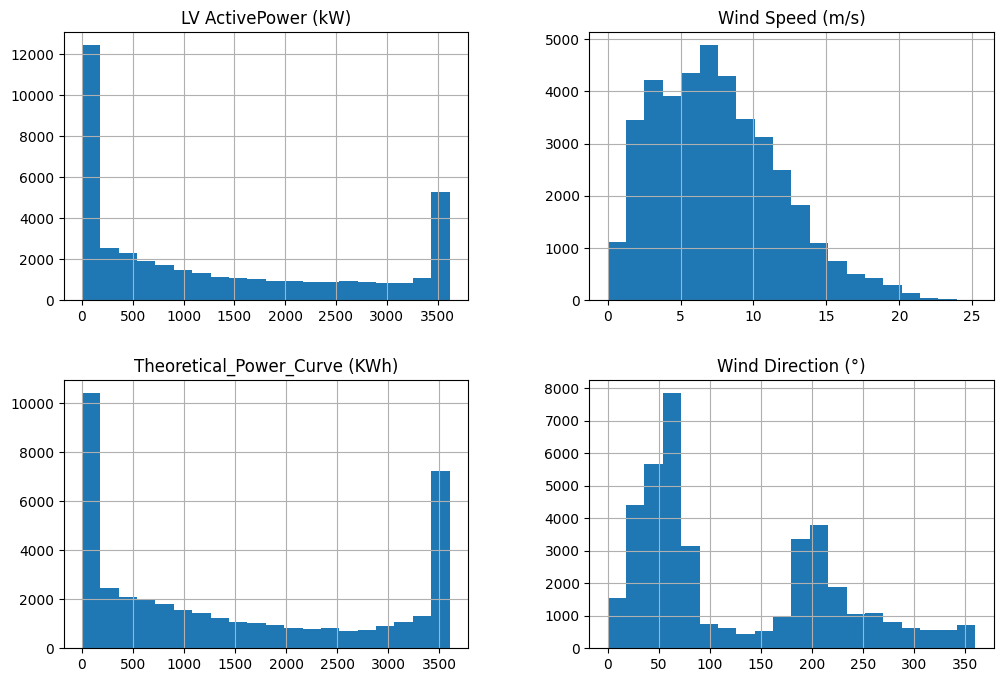

In [21]:
df_train[num_col].hist(bins=20,figsize=(12,8))

<a name="3.1"></a>
## 3.1 - Scatter matrix

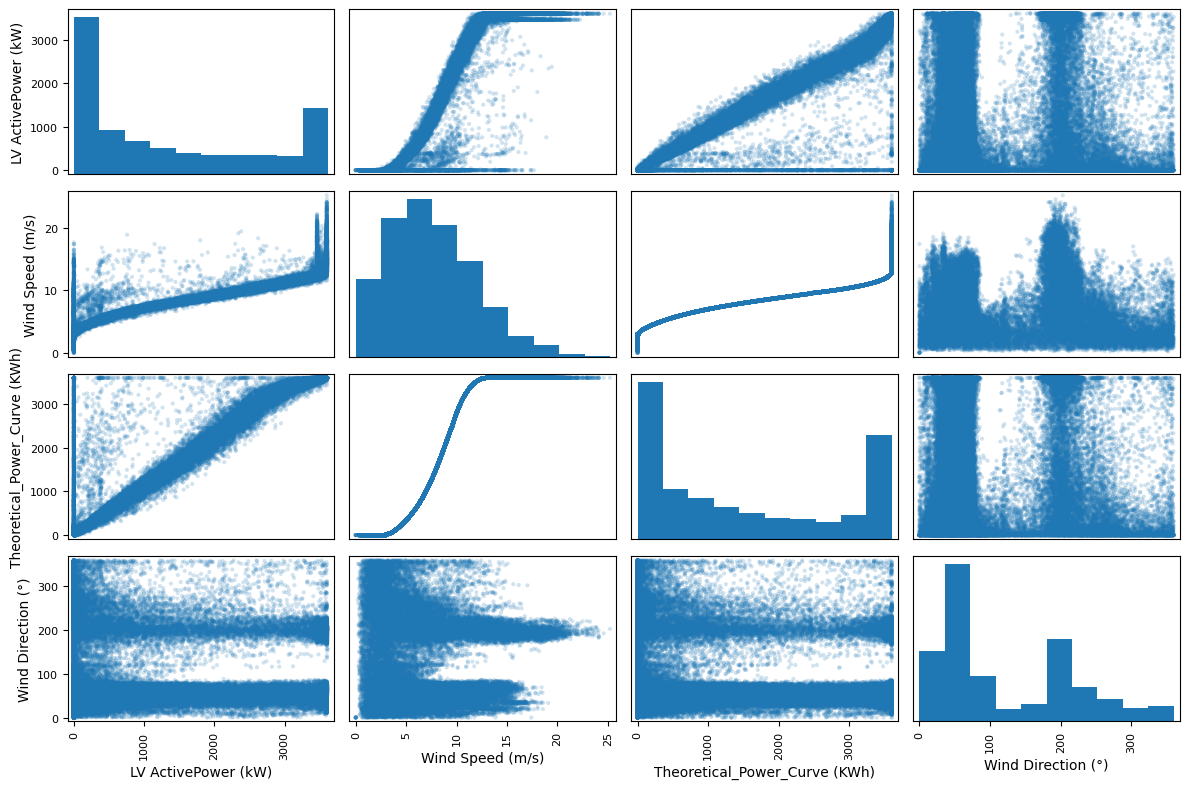

In [22]:
pd.plotting.scatter_matrix(df[num_col], alpha=0.2, figsize=(12, 8))
plt.tight_layout()
plt.show()

* Comments:
    * from the scatter plot between wind speed and Theoritical Power Curve, we see that Wind Turbines Systems can't generate any power if the wind speed is less than 4 m/s
    * when the wind speed is larger than 4 m/s to 11 m/s, the relation between them are linear meaning that increasing the wind speed, allows turbines to generate more power
    * after the wind speed passes 11 m/s, the power generated is saturated on 3600 KWh

<a name="3.2"></a>
## 3.2 - Univariate Analysis

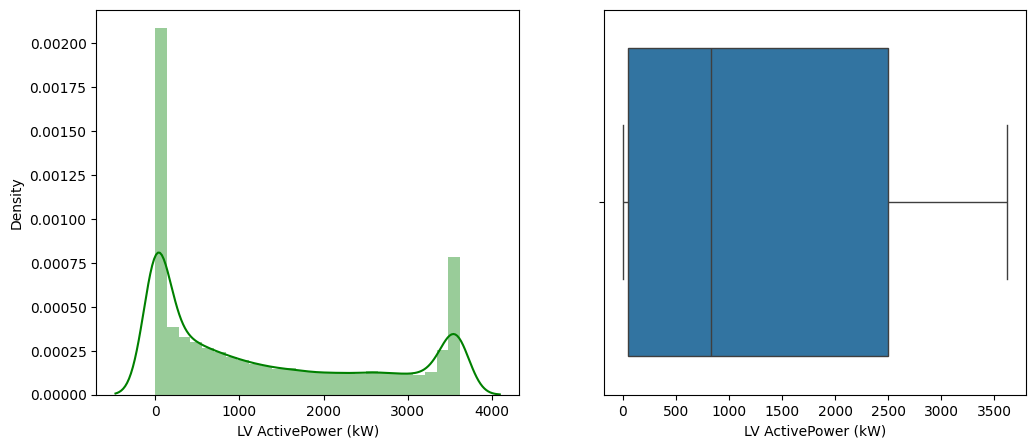

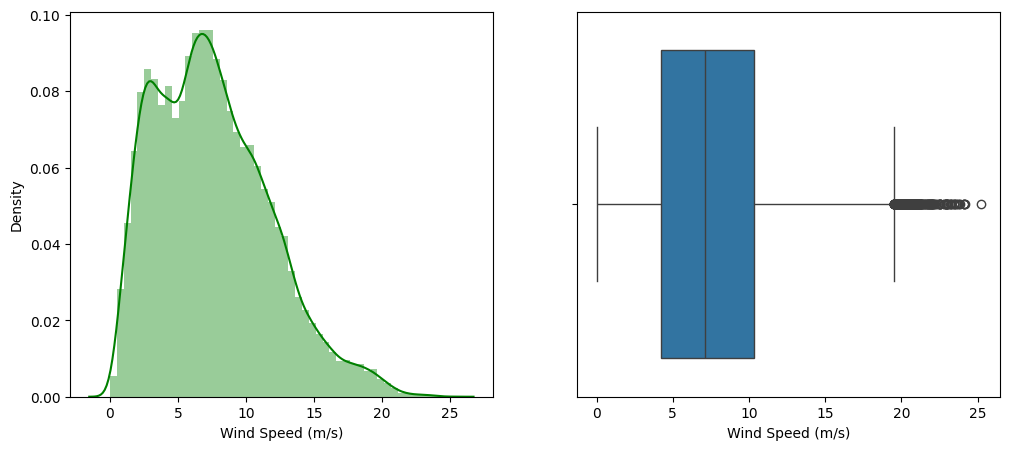

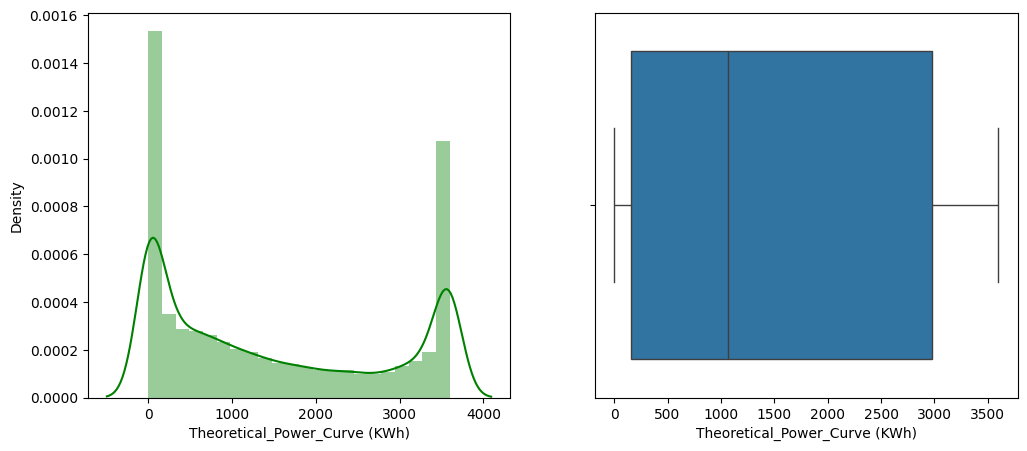

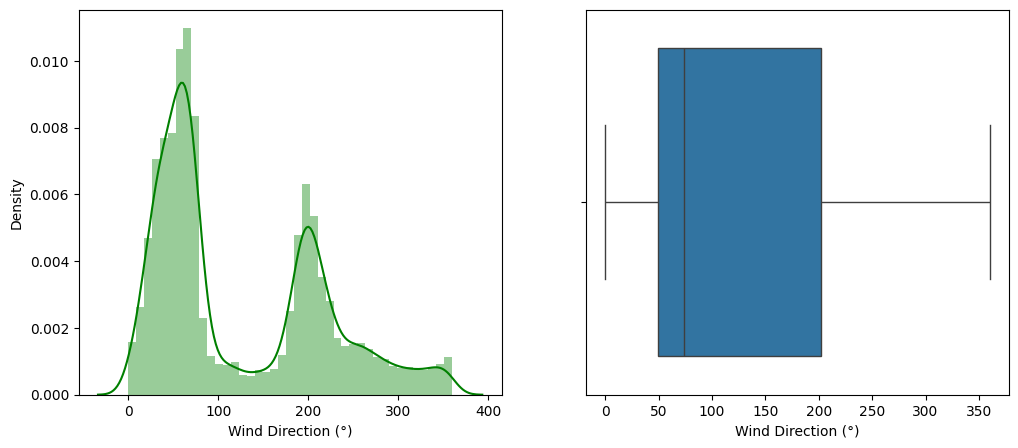

In [23]:
for col in num_col:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.distplot(df_train[col], ax=ax[0] ,color='green')  
    sns.boxplot(x=df_train[col], ax=ax[1])
    plt.show()

<a name="3.3"></a>
## 3.3 - Plotting Colinearity

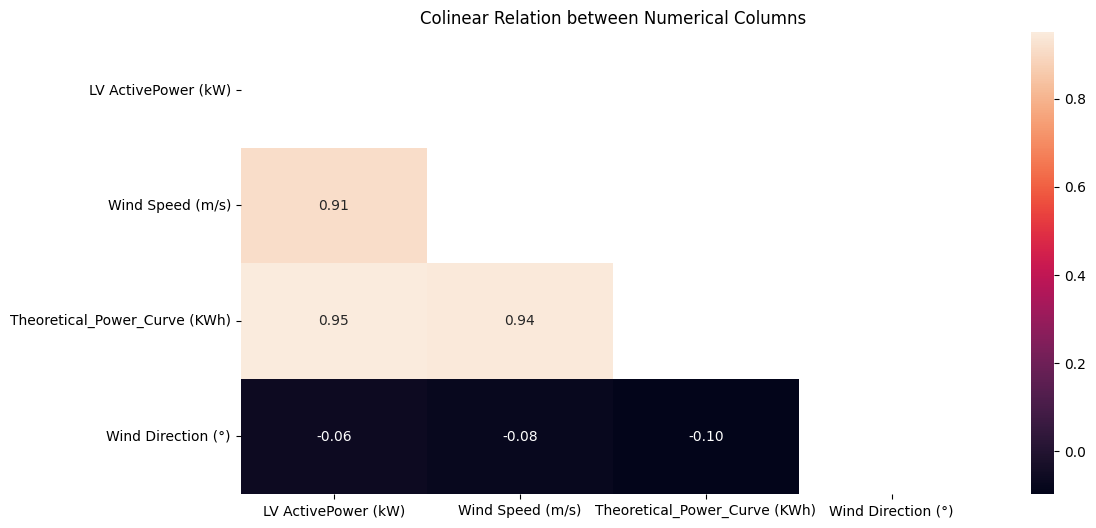

In [24]:
corr = df_train[num_col].corr(numeric_only=True)
mask = np.triu(corr)
mask=mask
plt.figure(figsize=(12, 6))
plt.title('Colinear Relation between Numerical Columns')
sns.heatmap(corr, annot=True,mask=mask, fmt='.2f')
sns.color_palette("magma", as_cmap=True)
plt.show()

<a name="3.4"></a>
## 3.4 - Numerical Columns over the date columns
#### Numerical Columns over the Weeks

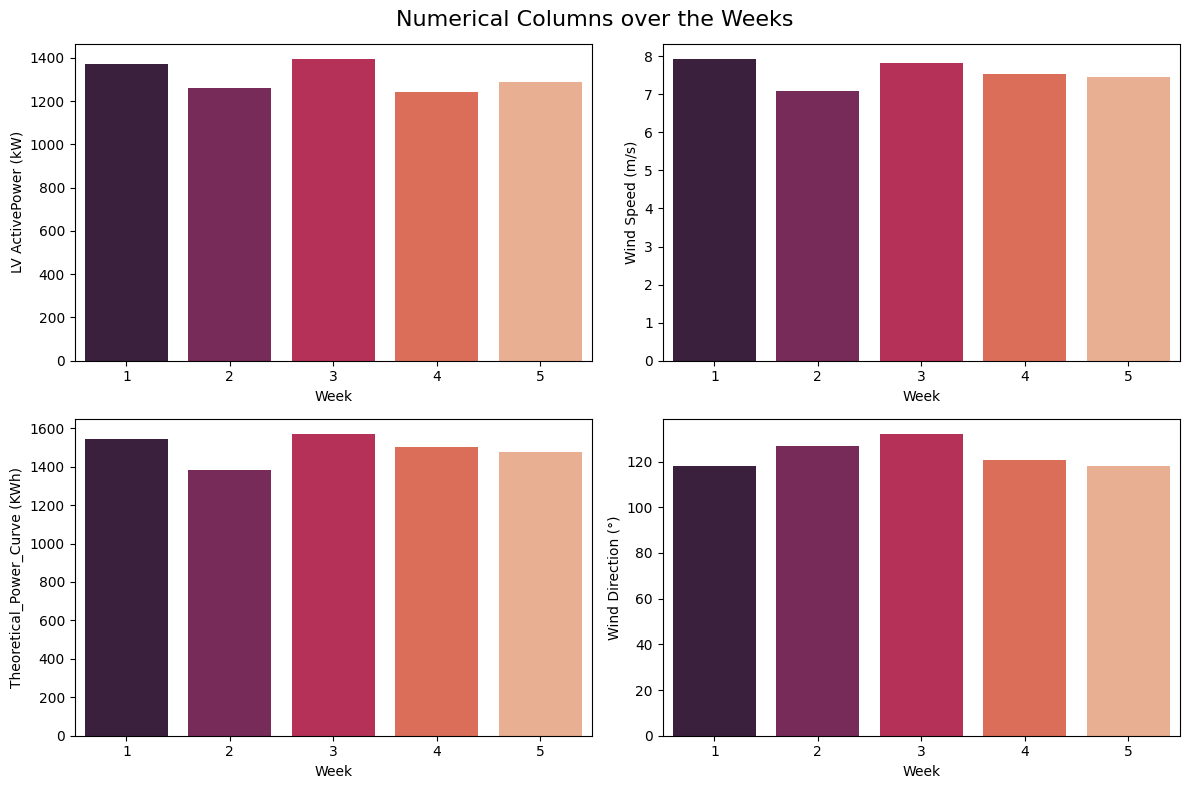

In [25]:
fig,axes=plt.subplots(nrows=len(num_col)//2 ,ncols=2,figsize=(12,8))
for idx,col in enumerate(df_train[num_col]):
    row_idx=idx//2
    col_idx=idx%2
    sns.barplot(x=df_train['Week'],y=df_train[col],data=df_train,ax=axes[row_idx,col_idx],errorbar=None,palette='rocket')
fig.suptitle('Numerical Columns over the Weeks', fontsize=16)
plt.tight_layout()
plt.show() 

### Numerical Columns for each Month

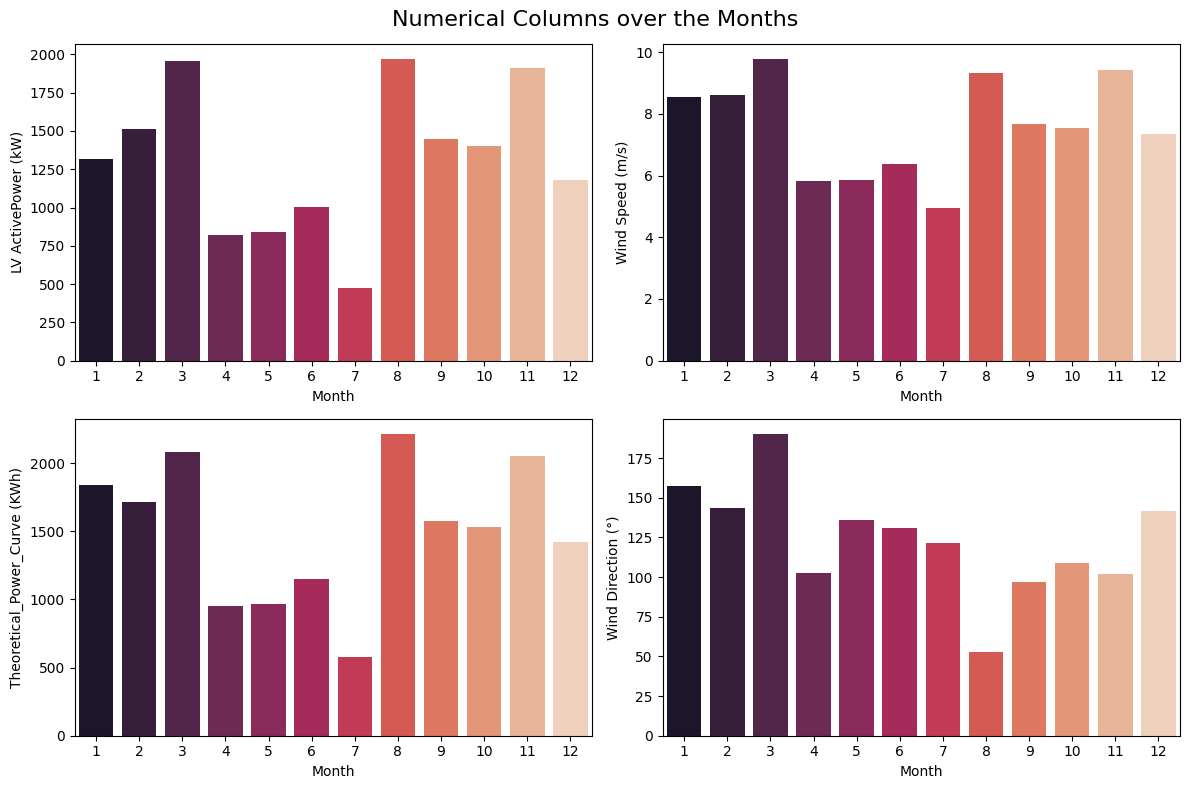

In [26]:
fig,axes=plt.subplots(nrows=len(num_col)//2 ,ncols=2,figsize=(12,8))
for idx,col in enumerate(df_train[num_col]):
    row_idx=idx//2
    col_idx=idx%2
    sns.barplot(x=df_train['Month'],y=df_train[col],data=df_train,ax=axes[row_idx,col_idx],errorbar=None,palette='rocket')
fig.suptitle('Numerical Columns over the Months', fontsize=16)
plt.tight_layout()
plt.show() 

### Numerical Columns over the Seasons

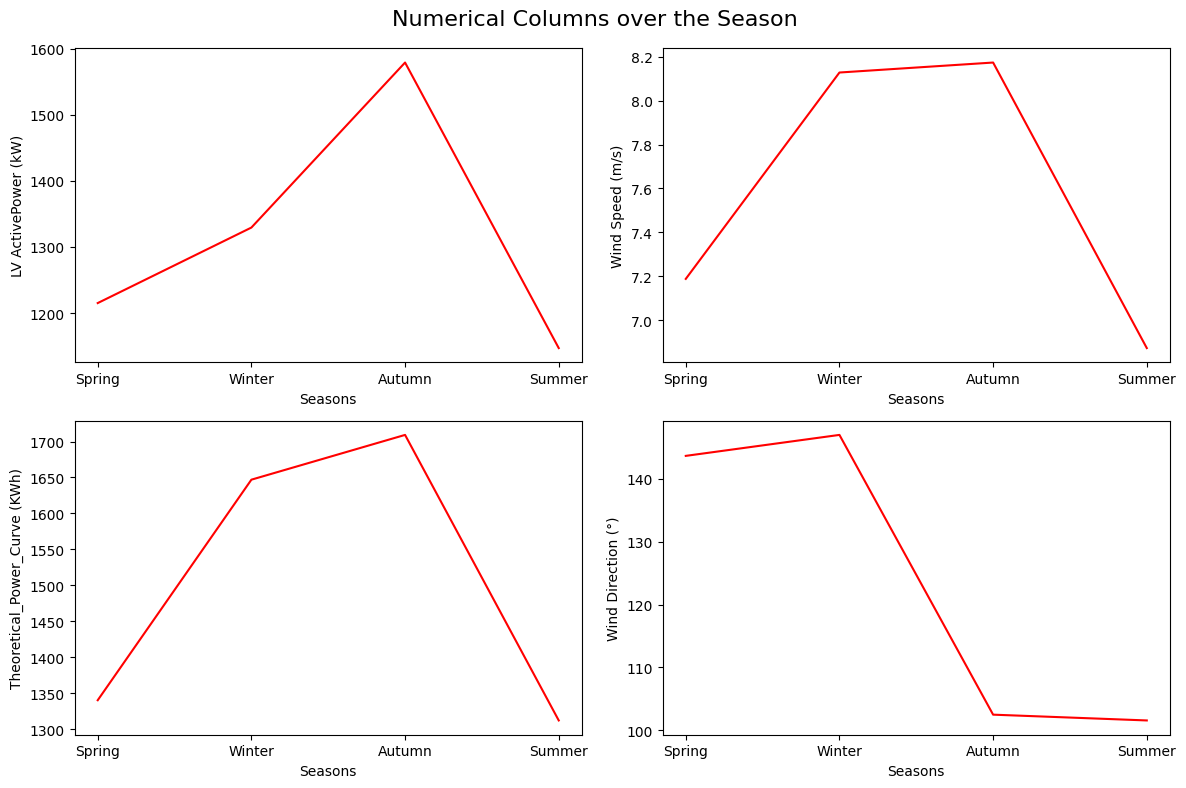

In [27]:
fig,axes=plt.subplots(nrows=len(num_col)//2 ,ncols=2,figsize=(12,8))
for idx,col in enumerate(df_train[num_col]):
    row_idx=idx//2
    col_idx=idx%2
    sns.lineplot(x='Seasons',y=df_train[col],data=df_train,ax=axes[row_idx,col_idx],ci=None,color='red')
fig.suptitle('Numerical Columns over the Season', fontsize=16)
plt.tight_layout()
plt.show() 

<a name="4"></a>
# 4 - Preprocessing

In [28]:
from sklearn.preprocessing import LabelEncoder, Normalizer, StandardScaler, MinMaxScaler, RobustScaler,OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.ensemble import RandomForestRegressor

### Split the Target and Label Columns

In [29]:
X_train,y_train,X_test,y_test=df_copy_train.drop(columns='LV ActivePower (kW)'),df_copy_train['LV ActivePower (kW)'],df_copy_test.drop(columns='LV ActivePower (kW)'),df_copy_test['LV ActivePower (kW)']

In [30]:
print("The Shape of X_train is :",X_train.shape)
print("The Shape of y_train is :",y_train.shape)
print("The Shape of X_test is :",X_test.shape)
print("The Shape of y_test is :",y_test.shape)

The Shape of X_train is : (40424, 4)
The Shape of y_train is : (40424,)
The Shape of X_test is : (10106, 4)
The Shape of y_test is : (10106,)


<a name="4.1"></a>
# 4.1 - Custom Transformers & Pipeline

In [32]:
class StandardScaleTransform(BaseEstimator, TransformerMixin):
    """
    A transformer class to apply standard scaling to specified columns in a Pandas DataFrame.

    Parameters
    ----------
    cols : list of str
        The names of the columns to apply standard scaling to.
    """
    def __init__(self, cols):
        self.cols = cols
        self.scaler_ = None

    def fit(self, X, y=None):
        self.scaler_ = StandardScaler().fit(X.loc[:, self.cols])
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy.loc[:, self.cols] = self.scaler_.transform(X_copy.loc[:, self.cols])
        return X_copy

    def fit_transform(self, X, y=None):
        self.scaler_ = StandardScaler().fit(X.loc[:, self.cols])
        return self.transform(X)

In [33]:
class DataFrameImputer(TransformerMixin, BaseEstimator):
    """
    A class to impute missing values in a Pandas DataFrame using a combination of median, knn, and most frequent
    imputers on specified columns.

    Parameters:
    -----------
    median_cols : list of str, optional (default=None)
        Columns to impute missing values using the median imputer.
    knn_cols : list of str, optional (default=None)
        Columns to impute missing values using the KNN imputer.

    Returns:
    --------
    X_imputed : pandas.DataFrame
        A DataFrame with imputed missing values.
    """
    def __init__(self, median_cols=None, knn_cols=None):
        self.median_cols = median_cols
        self.knn_cols = knn_cols
    
    def fit(self, X, y=None):
        self.median_imputer = SimpleImputer(strategy='median')
        self.knn_imputer = KNNImputer()

        if self.median_cols is not None:
            self.median_imputer.fit(X[self.median_cols])
        if self.knn_cols is not None:
            self.knn_imputer.fit(X[self.knn_cols])
        return self
    
    def transform(self, X):
        X_imputed = X.copy()
        if self.median_cols is not None:
            X_median = pd.DataFrame(self.median_imputer.transform(X[self.median_cols]), 
                                    columns=self.median_cols, index=X.index)
            X_imputed = pd.concat([X_imputed.drop(self.median_cols, axis=1), X_median], axis=1)
        if self.knn_cols is not None:
            X_knn = pd.DataFrame(self.knn_imputer.transform(X[self.knn_cols]), 
                                 columns=self.knn_cols, index=X.index)
            X_imputed = pd.concat([X_imputed.drop(self.knn_cols, axis=1), X_knn], axis=1)
        return X_imputed
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [34]:
class DateExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, date_cols):
        self.date_cols = date_cols
         

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        extracted_features = []
        for col in self.date_cols:
            dates = pd.to_datetime(X[col], format='%d %m %Y %H:%M')
            for date in dates:
                month_val = date.month
                week_val = date.day // 7 + 1
                day_val = date.day
                hour_val = date.hour + 1
                # Determining season based on month
                if month_val in [3, 4, 5]:
                    season_val = 'Spring'
                elif month_val in [6, 7, 8]:
                    season_val = 'Summer'
                elif month_val in [9, 10, 11]:
                    season_val = 'Autumn'
                else:
                    season_val = 'Winter'
                extracted_features.append([month_val, week_val, day_val, season_val, hour_val])

        # Convert the extracted features list to a DataFrame
        X_date = pd.DataFrame(extracted_features, columns=['Month', 'Week', 'Day', 'Season', 'Hour'])
        X_new=pd.concat([X.reset_index(drop=True),X_date],axis=1)
        return X_new
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [35]:
class OutlierThresholdTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column, q1=0.25, q3=0.75):
        self.column = column
        self.q1 = q1
        self.q3 = q3
    def outlier_threshhold(self, dataframe, column):
        Q1 = dataframe[column].quantile(self.q1)
        Q3 = dataframe[column].quantile(self.q3)
        iqr = Q3 - Q1
        up_limit = Q3 + 1.5 * iqr
        low_limit = Q1 - 1.5 * iqr
        return low_limit, up_limit

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.column:
            low_limit, up_limit = self.outlier_threshhold(X_copy, col)
            X_copy.loc[(X_copy[col] < low_limit), col] = low_limit
            X_copy.loc[(X_copy[col] > up_limit), col] = up_limit
        return X_copy

    def fit_transform(self, X, y=None):
        return self.transform(X)

In [36]:
class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    """
    A transformer that drops specified columns from a DataFrame.

    Parameters
    ----------
    columns : list
        A list of column names to be dropped.
    return
    ------
        dataframe with dropped columns
    """
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.columns is None:
            return X
        else:
            return X.drop(self.columns,axis=1)

In [37]:
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):

    """
    A transformer class to apply one-hot encoding to specified columns in a Pandas DataFrame.

    Parameters
    ----------
    columns : list
        A list of column names to encode.

    Returns
    -------
    pandas.DataFrame
        A new DataFrame with the specified columns one-hot encoded.
    """
    def __init__(self, columns=None):
        self.columns = columns
        self.unique_values = {} 
        self.feature_names_ = None

    def fit(self, X, y=None):
        if self.columns is None:
            self.columns = X.columns.tolist() 
        self.unique_values = {col: X[col].unique() for col in self.columns}
        self.feature_names_ = self._get_feature_names()
        return self
    def _get_feature_names(self):
        feature_names = []
        for col in self.columns:
            for value in self.unique_values[col]:
                feature_names.append(f"{col}_{value}")
        return feature_names
    def transform(self, X):
        X_transformed = pd.DataFrame(index=X[self.columns].index)
                                     
        for col in self.columns:
            for value in self.unique_values[col]:
                X_transformed[f"{col}_{value}"] = (X[col] == value).astype(int)
        
        X = pd.concat([X, X_transformed], axis=1)
        return X.drop(columns=['Season'])
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [38]:
class LabelEncodeColumns(BaseEstimator, TransformerMixin):
    """
    A transformer class to encode categorical columns using LabelEncoder.

    Parameters
    ----------
    columns : list of str
        The names of the columns to be encoded.

    return
    ------
        encoded feature
    """
    def __init__(self, columns):
        self.columns = columns
        self.encoders_ = {}

    def fit(self, X, y=None):
        for col in self.columns:
            encoder = LabelEncoder()
            encoder.fit(X[col])
            self.encoders_[col] = encoder
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col, encoder in self.encoders_.items():
            X_copy[col] = encoder.transform(X_copy[col])
        return X_copy

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

In [39]:
class FullPipeline1:
    def __init__(self) :
        self.date_cols=['Date/Time']
        self.numerical_cols=['Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)','Week','Month','Hour','Day']
        self.MLE_cols=['Season']
        self.full_pipeline=Pipeline([
            ('extract_date',DateExtractor(date_cols=self.date_cols)),
            ('label_encode', CustomOneHotEncoder(columns=self.MLE_cols)),
            #('label_encode', LabelEncodeColumns(columns=self.MLE_cols)),
            ('impute_num',DataFrameImputer(knn_cols=self.numerical_cols)),
            ('remove_outlier',OutlierThresholdTransformer(column=self.numerical_cols)),
            ('scale', StandardScaleTransform(cols=self.numerical_cols)),
            ('drop', DropColumnsTransformer(columns=self.date_cols)),
           
        ])
    def fit_transform(self, X_train):
        X_train = self.full_pipeline.fit_transform(X_train)
        return X_train
    def transform(self, X_test):
        X_test = self.full_pipeline.transform(X_test)
        return X_test
f1=FullPipeline1()
X_1_train_f1=f1.fit_transform(X_train)
X_1_test_f1=f1.transform(X_test)

In [40]:
X_1_train_f1.head()

,Season_Spring,Season_Winter,Season_Autumn,Season_Summer,Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Week,Month,Hour,Day
0,1,0,0,0,-1.131041,-1.091661,0.600542,-0.641252,-0.738439,-0.800917,-0.533974
1,0,1,0,0,-0.616778,-0.852852,-0.007299,-1.424629,1.605546,-0.800917,-1.569184
2,0,0,1,0,1.231326,1.531968,0.937698,1.708881,1.019550,0.928508,1.651468
3,0,0,0,1,-0.110304,-0.318188,-0.744266,-1.424629,-0.152443,-0.368561,-1.684207
4,1,0,0,0,-0.303991,-0.564102,-0.869168,1.708881,-1.031437,0.352033,1.421421


<a name="5"></a>
# 5 - Feature Importance

In [41]:
#Create and train a Random Forest regressor
model=RandomForestRegressor(random_state=42)
model.fit(X_1_train_f1,y_train)
feature_importance=model.feature_importances_
#Create a DataFrame to associate feature names with their importances
feature_importance_df=pd.DataFrame({'Feature':X_1_train_f1.columns,'Importance':feature_importance})
#Sort feature by importance
feature_importance_df=feature_importance_df.sort_values(by='Importance',ascending=False)

In [43]:
feature_importance_df

,Feature,Importance
4,Wind Speed (m/s),0.467188
5,Theoretical_Power_Curve (KWh),0.453834
6,Wind Direction (°),0.025089
10,Day,0.023817
8,Month,0.013416
9,Hour,0.008390
1,Season_Winter,0.003750
7,Week,0.003392
3,Season_Summer,0.000563
2,Season_Autumn,0.000319


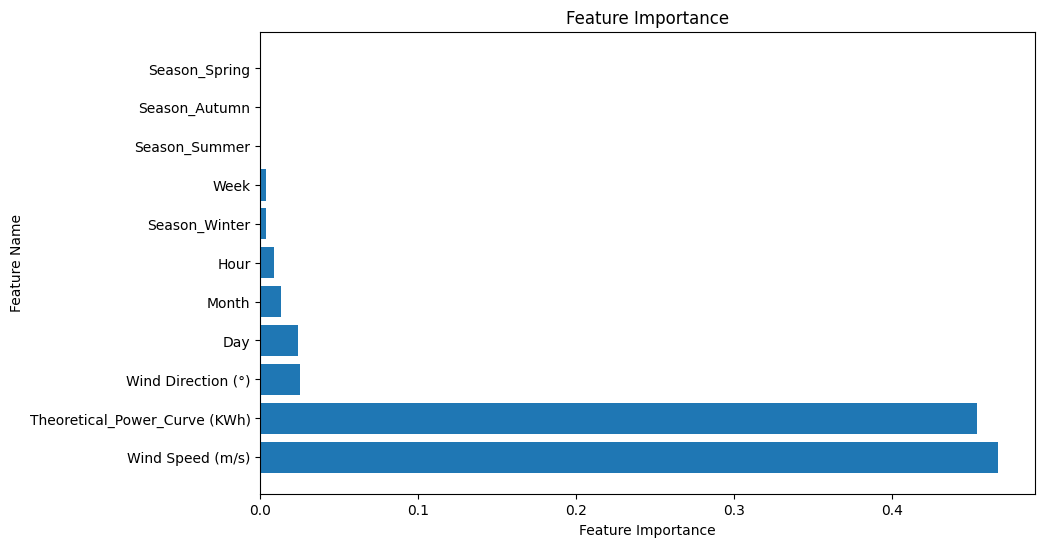

In [44]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance')
plt.show()

<a name="6"></a>
# 6 - Modeling

In [45]:
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor,XGBRFRegressor
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor

In [47]:
model_name = []
r2score = []
rmse = []

models = [
    GradientBoostingRegressor(random_state=42),
    SVR(),
    RandomForestRegressor(random_state=42),
    LinearRegression(),
    ExtraTreesRegressor(random_state=42),
    AdaBoostRegressor(random_state=42),
    DecisionTreeRegressor(random_state=42),
    XGBRegressor(random_state=42),
    XGBRFRegressor(random_state=42),
    CatBoostRegressor(random_state=42, verbose=False)
]

for model in models:
    model.fit(X_1_train_f1, y_train)
    y_pred = model.predict(X_1_test_f1)

    model_name.append(model.__class__.__name__)
    r2score.append(r2_score(y_test, y_pred) * 100)
    rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))

In [48]:
models_df = pd.DataFrame({"Model-Name":model_name, "R2_score": r2score ,'RMSE':rmse})
models_df = models_df.astype({"R2_score": float, "RMSE": float})
models_df.sort_values("R2_score", ascending = False)

,Model-Name,R2_score,RMSE
9,CatBoostRegressor,98.253759,172.616020
7,XGBRegressor,98.145471,177.887655
4,ExtraTreesRegressor,97.739542,196.393560
2,RandomForestRegressor,97.398450,210.690552
6,DecisionTreeRegressor,95.528001,276.235730
0,GradientBoostingRegressor,94.777728,298.509905
8,XGBRFRegressor,94.513065,305.980617
3,LinearRegression,90.607046,400.341024
1,SVR,88.491109,443.144887
5,AdaBoostRegressor,86.857825,473.546488


<a name="6.1"></a>
## 6.1 - Plot Model Scores

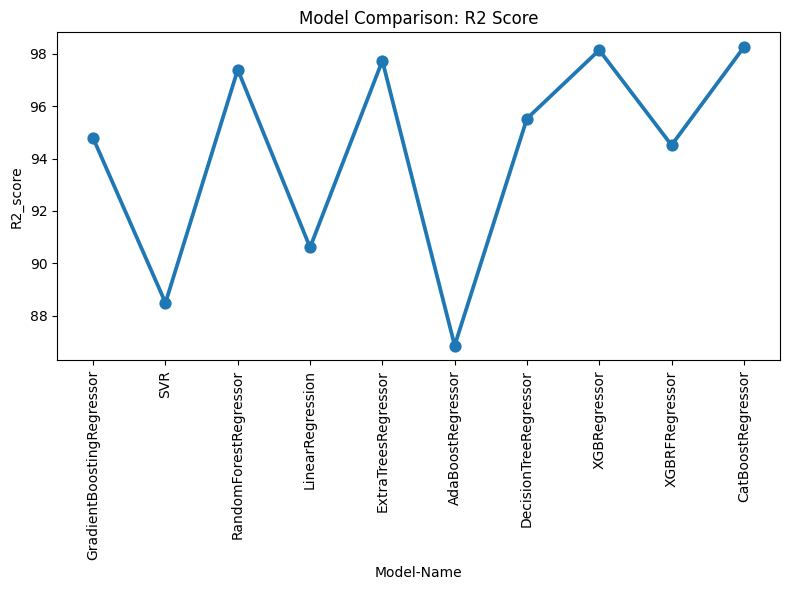

In [ ]:
plt.figure(figsize=(8,6))
sns.pointplot(x='Model-Name',y='R2_score',data=models_df)
plt.xticks(rotation=90)
plt.title('Model Comparison: R2 Score')
plt.tight_layout()
plt.show()

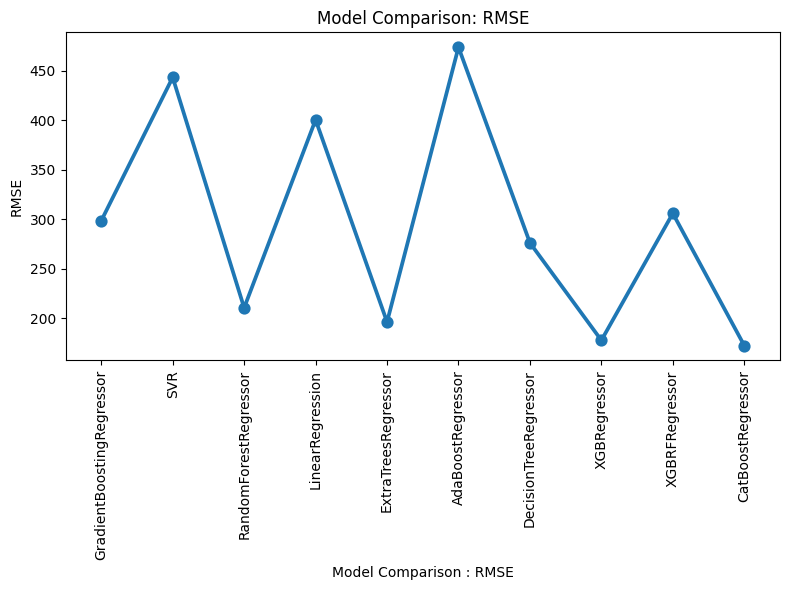

In [ ]:
plt.figure(figsize=(8,6))
plt.xlabel('Model Comparison : RMSE')
sns.pointplot(x='Model-Name',y='RMSE',data=models_df)
plt.xticks(rotation=90)
plt.title('Model Comparison: RMSE')
plt.tight_layout()
plt.show()

<a name="6.2"></a>
## 6.2 - Final Model

In [ ]:
fm=CatBoostRegressor(random_state=42)

#### Fine Tune your model

In [ ]:
#Prepare a set of hyperparameters to search over
param_grid = {
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'iterations': [100, 200, 300, 400, 500],  # Equivalent to n_estimators
    'depth': [3, 5, 7, 9],  # Equivalent to max_depth
    'subsample': np.linspace(0.5, 1.0, 6),
    'colsample_bylevel': np.linspace(0.5, 1.0, 6),  # Equivalent to colsample_bytree
    'l2_leaf_reg': np.linspace(0.01, 1.0, 10),  # Equivalent to reg_lambda
    'min_child_samples': [1, 5, 10, 15],  # Equivalent to min_child_weight 
}

In [ ]:
#Create the GridSearchCV object and specify the number of folds for cross-validation
from sklearn.metrics import make_scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)
random_search = RandomizedSearchCV(estimator=fm, param_distributions=param_grid, n_iter=50, scoring=rmse_scorer , n_jobs=-1,error_score='raise')

In [ ]:
#Fit the RandmoizedSearch object to your training data:
random_search.fit(X_1_train_f1, y_train, verbose=False)

,estimator,<catboost.cor...0017F49D11150>
,param_distributions,"{'colsample_bylevel': array([0.5, 0....8, 0.9, 1. ]), 'depth': [3, 5, ...], 'iterations': [100, 200, ...], 'l2_leaf_reg': array([0.01, ..., 0.89, 1. ]), ...}"
,n_iter,50
,scoring,make_scorer(r...hod='predict')
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,'raise'


In [ ]:
#Inspect the best parameters and score:
best_params = random_search.best_params_
best_score = random_search.best_score_
print('Best Parameters: ', best_params)
print('Best RMSE: ', best_score)

Best Parameters:  {'subsample': 1.0, 'min_child_samples': 1, 'learning_rate': 0.1388888888888889, 'l2_leaf_reg': 0.12, 'iterations': 500, 'depth': 9, 'colsample_bylevel': 0.9}
Best RMSE:  -150.11362323046092


In [ ]:
#Use the best parameters to re-train your model and make predictions on the test data:
best_model = CatBoostRegressor(**best_params)
best_model.fit(X_1_train_f1, y_train,verbose=False)
y_pred = best_model.predict(X_1_test_f1)

In [ ]:
import joblib
joblib.dump(f1, 'one_hot_pipeline.pkl')

['one_hot_pipeline.pkl']

In [ ]:
joblib.dump(best_model, 'one_hot_model.pkl')

['one_hot_model.pkl']

In [ ]:
y_test1=y_test.to_numpy()

In [ ]:
#Evaluate the performance of the best model using your preferred metric
r2 = r2_score(y_test1, y_pred )
print('R2 Score: ', r2)

R2 Score:  0.9869492355643507


In [ ]:
sample_data = {
    'Date/Time': ['31 12 2018 23:10'],
    'Wind Speed (m/s)': [11.404030],
    'Theoretical_Power_Curve (KWh)': [3397.190793],
    'Wind Direction (°)': [80.502724]
}
f_data = pd.DataFrame(sample_data)
f_data1=f1.transform(f_data)
best_model.predict(f_data1)

array([3108.57662883])

<a name="6.3"></a>
## 6.3 - Cross-Validation Scores

In [ ]:
cross_val=cross_val_score(best_model,X_1_test_f1,y_test,scoring=rmse_scorer ,cv=20,verbose=False)
print(cross_val)

0:	learn: 1144.8491639	total: 9.12ms	remaining: 4.55s
1:	learn: 1009.0176693	total: 21.4ms	remaining: 5.32s
2:	learn: 892.6403067	total: 31.9ms	remaining: 5.28s
3:	learn: 789.4842044	total: 44.5ms	remaining: 5.52s
4:	learn: 700.7662493	total: 66.8ms	remaining: 6.61s
5:	learn: 626.4541723	total: 80ms	remaining: 6.58s
6:	learn: 563.9177108	total: 92.6ms	remaining: 6.52s
7:	learn: 512.3996171	total: 105ms	remaining: 6.43s
8:	learn: 467.9651916	total: 117ms	remaining: 6.37s
9:	learn: 432.6554920	total: 130ms	remaining: 6.35s
10:	learn: 404.7780093	total: 142ms	remaining: 6.31s
11:	learn: 380.3334639	total: 152ms	remaining: 6.2s
12:	learn: 362.3847723	total: 164ms	remaining: 6.16s
13:	learn: 344.2568863	total: 177ms	remaining: 6.13s
14:	learn: 330.4320136	total: 189ms	remaining: 6.13s
15:	learn: 319.2733263	total: 203ms	remaining: 6.13s
16:	learn: 308.7015300	total: 217ms	remaining: 6.17s
17:	learn: 300.5296767	total: 229ms	remaining: 6.13s
18:	learn: 291.4725737	total: 243ms	remaining: 6.1

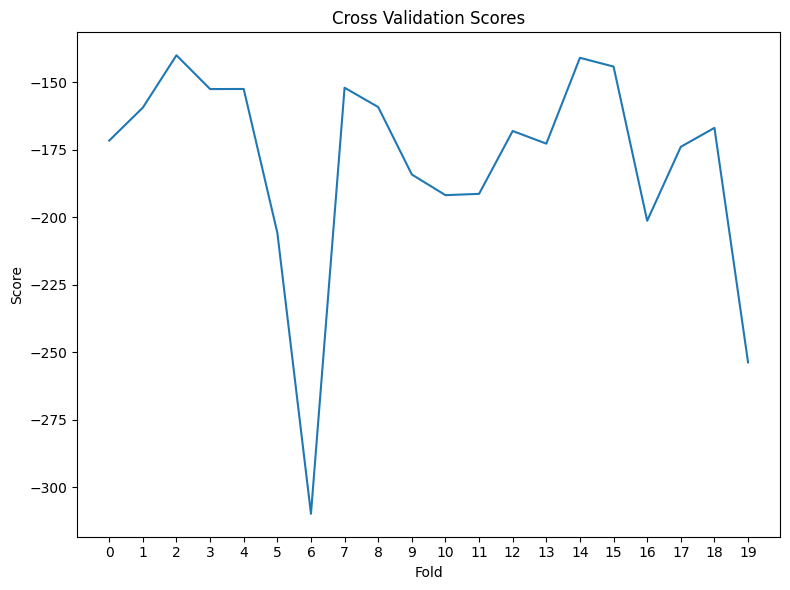

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(cross_val)
plt.title("Cross Validation Scores")
plt.ylabel("Score")
plt.xlabel("Fold")
plt.xticks(np.arange(0,20))
plt.tight_layout()
plt.show()

In [ ]:
print(cross_val.max())

-140.0827051899975


In [ ]:
data_new = pd.DataFrame({'LV ActivePower (kW)': y_test})
data_new['Predictions'] = y_pred
data_new["Theoretical_Power_Curve (KWh)"] = df["Theoretical_Power_Curve (KWh)"]

data_new.head()

,LV ActivePower (kW),Predictions,Theoretical_Power_Curve (KWh)
8057,3348.910889,3295.489705,3452.918718
8059,2647.506104,2744.896596,2989.120313
50250,0.000000,38.741728,779.117347
14774,1334.573975,1274.431182,1502.728868
49374,533.002808,583.753741,593.890170


<a name="7"></a>
# 7 - Plot Predicted/Real/Theoritical Power

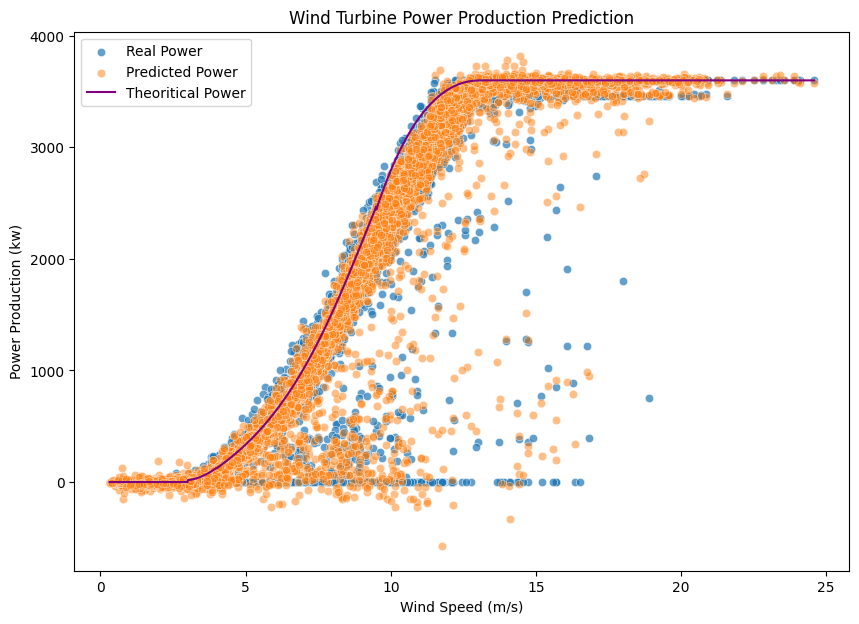

In [ ]:
# Visualizing real, theoritical and predicted power production
plt.figure(figsize=(10,7))
sns.scatterplot(x=df['Wind Speed (m/s)'], y=data_new['LV ActivePower (kW)'],alpha=0.7, label= 'Real Power')
sns.scatterplot(x=df['Wind Speed (m/s)'], y=data_new['Predictions'], alpha=0.5, label='Predicted Power', marker='o')
sns.lineplot(x=df['Wind Speed (m/s)'], y=data_new["Theoretical_Power_Curve (KWh)"], label='Theoritical Power',color='purple')
plt.title('Wind Turbine Power Production Prediction')
plt.ylabel('Power Production (kw)')
plt.legend()

the model fits better to the real power production, than the theoritical power production curve.